<img src="https://docs.google.com/uc?id=1bbeZmwDKLQi476oJdTo5btPwGvfkCe8Q"/>


<br>
<center><h1>Model Pipeline</h1></center>

The purpose of this notebook is to create a functional pipeline (data obtaining, data cleaning e feature engineering, until model training e score)


# 1. Solution strategy
    -> Project purpose
        -- 1. Which houses the CEO should be purchased and at what price to buy?
        -- 2. With the house in company possession, what is the best moment to be sold, and for which price?
        -- 3. The company should do a restoration to increase the price sale? What are the recommendations? For each 
        restoration recommendation, how the price increases?

    -> Solution proposal
        -- 1. Table (House | Purchase price) by EDA
            -- Houses that are cheap with high indicators of valuation
        -- 2. Table (House | Sale date | Sale price) --> ML Model
        -- 3. Table (House | Restoration (0, 1)
                    (House | Restoration Features | Sale price correlation)
                    
# 2. Solution steps
    -- C1. Understanding data (Finding data inconsistency and cleaning)
        -- transform date into datetime
        -- drop bedrooms < 1 and bedrooms outliers
        -- drop grade == 3
        -- knowing the features
    -- C2. Feature engineering (New features that can be useful to data model)
    -- C3. Hypotheses   
        -- H1. Oldest houses have an average higher price;
        -- H2. Houses that were renovated are more expensive than those that haven't been renovated and built in the same year;
        -- H3. The waterfront has no impact on the purchase price;
        -- H4. Houses with more sqft_living are more expensive;
        -- H5. The number of bedrooms are the more important categorical feature to increase the price purchase    
        -- H6. Mountain houses have a higher price;
        -- H7. Seattle has the highest value houses
        -- H8. Houses with basement living space are cheaper than no underground level    
        -- H9. Houses with repeated ids were bought for lower prices
        -- H10. The price of houses purchased doesn't influence by periods, like month or season.
    -- C4. Exploratory Data Analysis 
        -- Hypotheses validation
        -- Multivariate Analysis
    -- C6. Model Pipeline (Data obtaining until model training)

## 1.0 Imports

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from sklearn.cluster import KMeans

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

# data visualization config
from IPython.core.pylabtools import figsize
%matplotlib inline
sns.set(figsize(15, 8))
sns.set(font_scale=1.35)
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# C6. Functional Pipeline (Data obtaining until model training) 

## 2.0 Loading data

In [3]:
data = pd.read_csv('./data/kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


## 3.0 Data preparation

Preparing data to input in machine learning model (such as dropping null values and features that is not useful)

### Data cleaning
    -- dropped bedrooms < 1 (commercial houses?)
    -- dropped bedrooms outliers (33 bedrooms and 1 bathroom)
    -- dropped bathrooms < 0.75
    -- round bathrooms 0.75 to 1
    -- drop grade == 3 (just 1 case)

In [4]:
# data.query('bedrooms < 1')

# droping bedrooms < 1
idx_no_bedrooms = data.query('bedrooms < 1').index
data.drop(idx_no_bedrooms, inplace = True)
print(f'bedrooms < 1: {len(idx_no_bedrooms)} rows dropped')

bedrooms < 1: 13 rows dropped


In [5]:
idx_bedrooms_outlier = data.query('bedrooms == 33').index
data.drop(idx_bedrooms_outlier, inplace=True)
print(f'bedrooms outliers: {len(idx_bedrooms_outlier)} rows dropped')

bedrooms outliers: 1 rows dropped


In [6]:
# data.query('bathrooms < 1').describe()

# if bathrooms <= 0.5 then 0
# if bathrooms > 0.5 and < 1 then 1

drop_bathrooms = data.query('bathrooms <= 0.5').index
data.drop(drop_bathrooms, inplace = True)

# reducing the dimensionality of bathrooms (2.25 bathrooms => 2 | 2.75 => 3 | 2.5 => 2.5; etc.)
data['bathrooms'] = round(data['bathrooms'])

In [7]:
idx_drop = data.query('grade == 3').index
data.drop(idx_drop, inplace = True)

### Feature engineering
    -- total rooms (bedrooms + bathrooms)
    -- basement_living (does house have a basement living? - true | false)
    -- renovated (does house renovated? - true | false)
    -- sqft_living/total_rooms
    -- yr_built_yr_purchase_dif
    -- neighborhood

In [8]:
def transform_str_into_date(str_date):
    year = str_date[:4]
    month = str_date[4:6]
    day = str_date[6:8]
    return dt.strptime(f'{year}-{month}-{day}', '%Y-%m-%d')

data['date'] = data['date'].apply(transform_str_into_date)
data[['date']].sample(10).T

,13646,15698,6146,19032,4666,14706,429,15797,15060,2337
date,2015-04-13,2014-06-06,2014-08-26,2014-10-17,2014-06-23,2014-12-09,2015-05-12,2014-12-04,2015-04-13,2015-05-04


In [9]:
data['total_rooms'] = data['bedrooms'] + data['bathrooms']
data['basement_living'] = data['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
data['renovated'] = data['yr_renovated'].apply(lambda x: 0 if x == 0 else 1 )
data['sqft_living/total_rooms'] =  data['sqft_living'] / data['total_rooms']

data['year'] = data['date'].apply(lambda x: x.year)
data['yr_built_yr_purchase_dif'] =  data['yr_built'] - data['year']

In [10]:
kmeans = KMeans(n_clusters = 9, algorithm='elkan', random_state = 2102)
kmeans.fit(data[['lat','long']])
data['neighborhood'] = kmeans.predict(data[['lat','long']])

In [11]:
#avg_cluster_price = dict(data.groupby('neighborhood')['price'].mean())
#data['avg_cluster_price'] = data['neighborhood'].apply(lambda cluster: avg_cluster_price[cluster])

In [12]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,basement_living,renovated,sqft_living/total_rooms,year,yr_built_yr_purchase_dif,neighborhood
0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650,4.00,0,0,295.00,2014,-59,0
1,6414100192,2014-12-09,538000.00,3,2.00,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639,5.00,1,1,514.00,2014,-63,3
2,5631500400,2015-02-25,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062,3.00,0,0,256.67,2015,-82,5
3,2487200875,2014-12-09,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000,7.00,1,0,280.00,2014,-49,0
4,1954400510,2015-02-18,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503,5.00,0,0,336.00,2015,-28,1


### Data wrangling

In [13]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'total_rooms',
       'basement_living', 'renovated', 'sqft_living/total_rooms', 'year',
       'yr_built_yr_purchase_dif', 'neighborhood'],
      dtype='object')

In [14]:
model_data = data.drop(['id', 
                        'date', 
                        'sqft_living', 
                        #'sqft_above',
                        #'sqft_basement',
                        'yr_built', 
                        'sqft_living15', 
                        'sqft_lot15', 
                        'year', 
                        #'zipcode', 
                        'lat', 
                        'long', 
                        'yr_renovated',
                        #'condition',
                        'sqft_lot'
                       ], 
                       axis = 1)
model_data.head()

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,total_rooms,basement_living,renovated,sqft_living/total_rooms,yr_built_yr_purchase_dif,neighborhood
0,221900.00,3,1.00,1.00,0,0,3,7,1180,0,98178,4.00,0,0,295.00,-59,0
1,538000.00,3,2.00,2.00,0,0,3,7,2170,400,98125,5.00,1,1,514.00,-63,3
2,180000.00,2,1.00,1.00,0,0,3,6,770,0,98028,3.00,0,0,256.67,-82,5
3,604000.00,4,3.00,1.00,0,0,5,7,1050,910,98136,7.00,1,0,280.00,-49,0
4,510000.00,3,2.00,1.00,0,0,3,8,1680,0,98074,5.00,0,0,336.00,-28,1


##### transforming features in a normal distribution

In [15]:
numeric_feats = model_data.dtypes[model_data.dtypes != 'object'].index

skewed_feats = model_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness

,Skew
waterfront,11.38
renovated,4.55
price,4.03
view,3.40
sqft_basement,1.58
sqft_above,1.45
sqft_living/total_rooms,1.15
bathrooms,1.10
condition,1.04
grade,0.79


skewness > 0 : more weight in the left tail of the distribution.

skewness = 0 : normally distributed.

skewness < 0 : more weight in the right tail of the distribution.

In [16]:
skewness_feat_to_transform = [#'sqft_lot', 
                              #'sqft_living',
                              'sqft_basement', 
                              'sqft_above', 
                              'sqft_living/total_rooms']

lamb = 0.15
for feature in skewness_feat_to_transform:
    model_data[feature] = boxcox1p(model_data[feature], lamb)
    #model_data[feature] = np.log1p(model_data[feature])

In [17]:
skewed_feats = model_data[skewness_feat_to_transform].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness

,Skew
sqft_basement,0.54
sqft_above,0.42
sqft_living/total_rooms,0.36


In [18]:
model_data.head()

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,total_rooms,basement_living,renovated,sqft_living/total_rooms,yr_built_yr_purchase_dif,neighborhood
0,221900.00,3,1.00,1.00,0,0,3,7,12.60,0.00,98178,4.00,0,0,8.99,-59,0
1,538000.00,3,2.00,2.00,0,0,3,7,14.44,9.72,98125,5.00,1,1,10.34,-63,3
2,180000.00,2,1.00,1.00,0,0,3,6,11.40,0.00,98028,3.00,0,0,8.66,-82,5
3,604000.00,4,3.00,1.00,0,0,5,7,12.26,11.86,98136,7.00,1,0,8.86,-49,0
4,510000.00,3,2.00,1.00,0,0,3,8,13.64,0.00,98074,5.00,0,0,9.29,-28,1


##### dummy features

In [19]:
dummy_feat = [
    #'waterfront', 
    #'view', 
    #'condition',  
    'neighborhood' 
    #'basement_living', 
    #'renovated'
]

model_data = pd.get_dummies(model_data, columns=dummy_feat)

##### exponential features

In [20]:
model_data['bathrooms'] = model_data['bathrooms'].apply(lambda x: pow(x, 2))
model_data['grade'] = model_data['grade'].apply(lambda x: pow(x, 2))
model_data['view'] = model_data['view'].apply(lambda x: pow(x, 2))
model_data['total_rooms'] = model_data['total_rooms'].apply(lambda x: pow(x, 2))

In [21]:
model_data.sample(10)

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,total_rooms,basement_living,renovated,sqft_living/total_rooms,yr_built_yr_purchase_dif,neighborhood_0,neighborhood_1,neighborhood_2,neighborhood_3,neighborhood_4,neighborhood_5,neighborhood_6,neighborhood_7,neighborhood_8
4808,567000.00,3,4.00,2.00,0,0,3,81,14.94,0.00,98034,25.00,0,0,10.31,-15,0,0,0,0,0,1,0,0,0
12159,418000.00,3,4.00,1.00,0,0,5,64,13.01,11.22,98059,25.00,1,0,9.81,-36,0,0,0,0,0,0,0,0,1
15105,660000.00,3,4.00,3.00,0,0,3,64,13.80,0.00,98122,25.00,0,0,9.42,-15,1,0,0,0,0,0,0,0,0
15500,360000.00,2,4.00,3.00,0,0,3,64,12.97,0.00,98133,16.00,0,0,9.29,-6,0,0,0,1,0,0,0,0,0
9036,667000.00,3,9.00,1.00,0,0,3,81,14.51,0.00,98092,36.00,0,1,9.52,-47,0,0,1,0,0,0,0,0,0
14380,519000.00,3,4.00,1.00,0,9,4,64,13.42,0.00,98070,25.00,0,0,9.12,-42,1,0,0,0,0,0,0,0,0
15877,282500.00,4,1.00,1.00,0,0,4,49,13.59,0.00,98059,25.00,0,0,9.25,-50,0,0,0,0,0,0,0,0,1
5181,639000.00,3,4.00,2.00,0,0,3,81,13.10,0.00,98034,25.00,0,0,8.86,-10,0,0,0,0,0,1,0,0,0
11118,545000.00,4,4.00,1.00,0,0,4,64,14.75,0.00,98072,36.00,0,0,9.71,-45,0,0,0,0,0,1,0,0,0
4000,210000.00,2,4.00,1.00,0,0,4,64,12.13,0.00,98198,16.00,0,0,8.60,-39,0,0,0,0,0,0,0,1,0


In [22]:
#from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(degree=2)
#poly_feat = poly.fit_transform(model_data[['bathrooms', 'grade', 'view', 'total_rooms']])

In [23]:
#model_data.reset_index(drop=True, inplace=True)
#model_data = model_data.join(pd.DataFrame(poly_feat))

In [24]:
#model_data.head()

In [25]:
#model_data.drop(['bathrooms', 'grade', 'view', 'total_rooms'], axis=1, inplace=True)

##### train test split

In [26]:
X = model_data.copy()
y = model_data['price'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=2102)

In [27]:
X_train.head()

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,total_rooms,basement_living,renovated,sqft_living/total_rooms,yr_built_yr_purchase_dif,neighborhood_0,neighborhood_1,neighborhood_2,neighborhood_3,neighborhood_4,neighborhood_5,neighborhood_6,neighborhood_7,neighborhood_8
12478,498000.00,3,4.00,1.50,0,0,4,64,13.72,0.00,98118,25.00,0,0,9.35,-106,1,0,0,0,0,0,0,0,0
17187,531800.00,3,4.00,2.00,0,0,3,49,14.07,0.00,98053,25.00,0,0,9.63,-11,0,1,0,0,0,0,0,0,0
16774,457000.00,3,1.00,1.50,0,0,4,49,12.57,0.00,98117,16.00,0,0,8.97,-90,0,0,0,1,0,0,0,0,0
4652,238000.00,3,1.00,1.00,0,0,3,49,12.18,10.01,98042,16.00,1,0,9.51,-56,0,0,1,0,0,0,0,0,0
21011,515000.00,5,9.00,2.00,0,0,3,81,15.47,0.00,98028,64.00,0,0,9.54,-7,0,0,0,0,0,1,0,0,0


##### aplying mean price by zipcode

In [28]:
avg_zipcode_price = X_train.groupby('zipcode')['price'].mean().round(2).to_dict()

In [29]:
X_train.insert(X_train.shape[1], 'avg_zipcode_price', np.log1p(X_train['zipcode'].apply(lambda x: avg_zipcode_price[x])))
X_test.insert(X_test.shape[1], 'avg_zipcode_price', np.log1p(X_test['zipcode'].apply(lambda x: avg_zipcode_price[x])))

In [30]:
X_test.drop(['price', 'zipcode'], axis=1, inplace=True)
X_train.drop(['price', 'zipcode'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [31]:
X_train.head()

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,total_rooms,basement_living,renovated,sqft_living/total_rooms,yr_built_yr_purchase_dif,neighborhood_0,neighborhood_1,neighborhood_2,neighborhood_3,neighborhood_4,neighborhood_5,neighborhood_6,neighborhood_7,neighborhood_8,avg_zipcode_price
12478,3,4.00,1.50,0,0,4,64,13.72,0.00,25.00,0,0,9.35,-106,1,0,0,0,0,0,0,0,0,12.95
17187,3,4.00,2.00,0,0,3,49,14.07,0.00,25.00,0,0,9.63,-11,0,1,0,0,0,0,0,0,0,13.43
16774,3,1.00,1.50,0,0,4,49,12.57,0.00,16.00,0,0,8.97,-90,0,0,0,1,0,0,0,0,0,13.27
4652,3,1.00,1.00,0,0,3,49,12.18,10.01,16.00,1,0,9.51,-56,0,0,1,0,0,0,0,0,0,12.65
21011,5,9.00,2.00,0,0,3,81,15.47,0.00,64.00,0,0,9.54,-7,0,0,0,0,0,1,0,0,0,13.04


In [32]:
X_test.head()

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,total_rooms,basement_living,renovated,sqft_living/total_rooms,yr_built_yr_purchase_dif,neighborhood_0,neighborhood_1,neighborhood_2,neighborhood_3,neighborhood_4,neighborhood_5,neighborhood_6,neighborhood_7,neighborhood_8,avg_zipcode_price
11894,2,4.00,1.00,0,4,5,64,12.18,11.64,16.00,1,0,10.09,-58,1,0,0,0,0,0,0,0,0,13.32
9086,4,4.00,1.00,0,0,4,49,12.67,12.13,36.00,1,0,9.51,-40,0,0,0,0,1,0,0,0,0,12.81
5917,4,4.00,1.00,0,0,5,49,12.40,12.13,36.00,1,0,9.39,-99,0,0,0,1,0,0,0,0,0,13.66
5403,3,4.00,3.00,0,0,3,64,13.20,0.00,25.00,0,0,8.95,-14,0,0,0,1,0,0,0,0,0,13.35
18771,3,4.00,2.00,0,0,3,64,13.99,0.00,25.00,0,0,9.56,-21,0,0,1,0,0,0,0,0,0,12.61


##### target

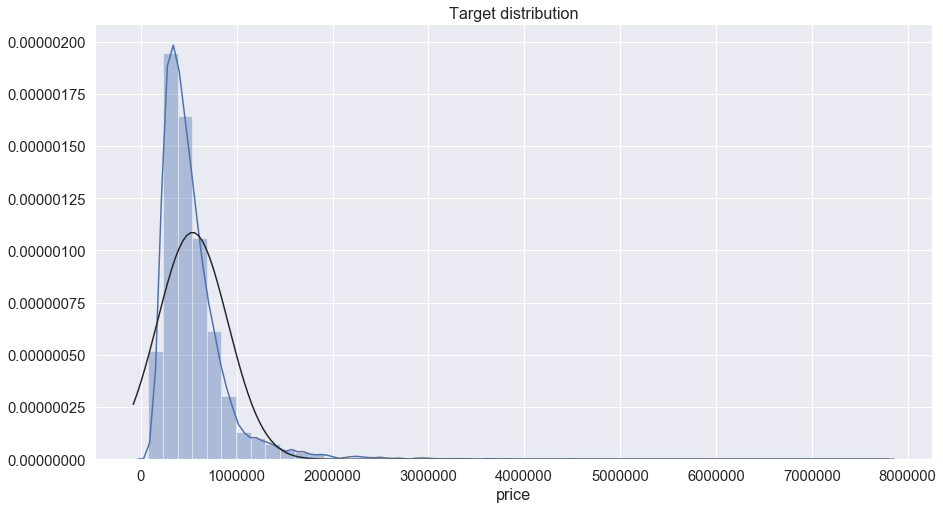

In [33]:
sns.distplot(y_train, fit=norm).set_title('Target distribution');

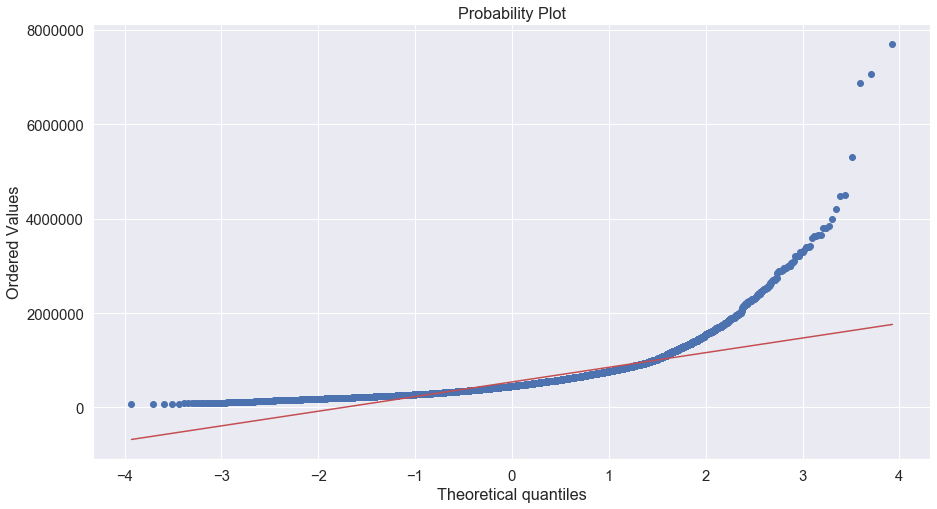

In [34]:
stats.probplot(y_train, plot=plt);

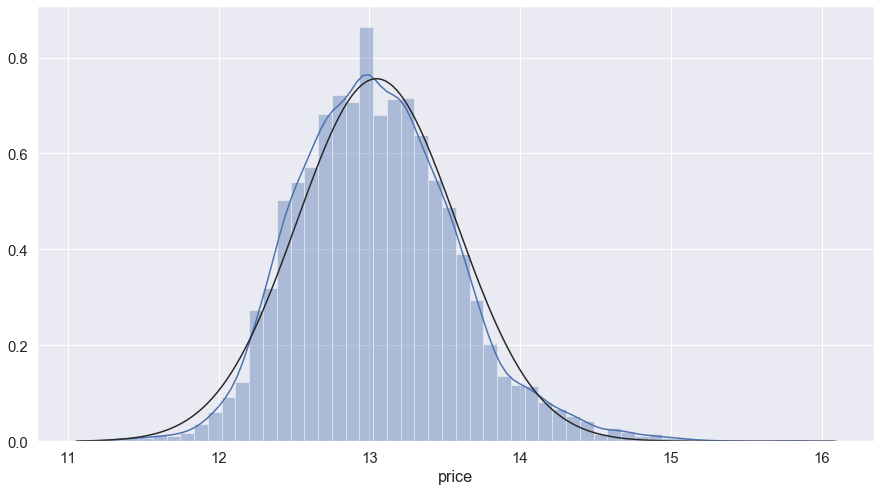

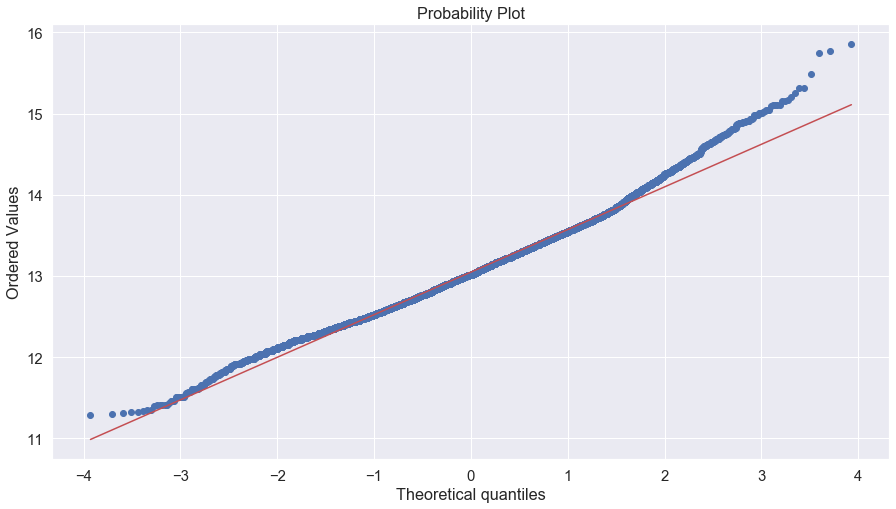

In [35]:
# applies log(1+x) to all elements in target
y_ = np.log1p(y_train)

#Check the new distribution 
sns.distplot(y_ , fit=norm);

fig = plt.figure()
stats.probplot(y_, plot=plt)
plt.show()

In [36]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

## 4.0 Machine Learning Base Models

Creating, training and predict the machine learning model

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
#from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [38]:
X_train.head()

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,total_rooms,basement_living,renovated,sqft_living/total_rooms,yr_built_yr_purchase_dif,neighborhood_0,neighborhood_1,neighborhood_2,neighborhood_3,neighborhood_4,neighborhood_5,neighborhood_6,neighborhood_7,neighborhood_8,avg_zipcode_price
12478,3,4.00,1.50,0,0,4,64,13.72,0.00,25.00,0,0,9.35,-106,1,0,0,0,0,0,0,0,0,12.95
17187,3,4.00,2.00,0,0,3,49,14.07,0.00,25.00,0,0,9.63,-11,0,1,0,0,0,0,0,0,0,13.43
16774,3,1.00,1.50,0,0,4,49,12.57,0.00,16.00,0,0,8.97,-90,0,0,0,1,0,0,0,0,0,13.27
4652,3,1.00,1.00,0,0,3,49,12.18,10.01,16.00,1,0,9.51,-56,0,0,1,0,0,0,0,0,0,12.65
21011,5,9.00,2.00,0,0,3,81,15.47,0.00,64.00,0,0,9.54,-7,0,0,0,0,0,1,0,0,0,13.04


### Cross validation

In [39]:
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=1997).get_n_splits(X_train.values)
    mae = cross_val_score(model, X_train.values, y_train, scoring='neg_mean_absolute_error', cv=kf, n_jobs=3)
    return mae

### Base Models

In [40]:
LR = LinearRegression()

# Random forest
# No linear model, may be good because the N dummy features
RF = RandomForestRegressor(random_state=1997)
    #min_samples_split=10, 
   #min_samples_leaf=0, 
   #max_leaf_nodes=100, 
   #oob_score=True,
   #random_state=1997)

# Lasso: 
# very sensitive to outliers. So we need to made it more robust.
# For that we use Robustscaler() on pipeline 
lasso = make_pipeline(RobustScaler(), Lasso(random_state=1997))

# ElasticNet
# L1 and L2 combined as regularizer penalizing large weights/diferrences
# L1 = 0 fit better in tests
ENet = make_pipeline(RobustScaler(), ElasticNet(random_state=1997))

# Kernel Ridge
# using a more exponential model instead linear
KRR = KernelRidge(kernel='polynomial', degree=3, coef0=1.5)

# Gradient Boosting
GBoost = GradientBoostingRegressor()

# XGBoost
XGB = xgb.XGBRegressor()

# LightGBM
LGBM = lgb.LGBMRegressor(objective='regression')

In [41]:
#score = rmsle_cv(LR)
#print(f'LinearRegressor score: {1 + score.mean()}')

In [42]:
#score = rmsle_cv(RF)
#print(f'RandomForest score: {1 + score.mean()}')

In [43]:
#score = rmsle_cv(lasso)
#print(f'Lasso score: {1 + score.mean()}')

In [44]:
#score = rmsle_cv(ENet)
#print(f'ElasticNet score: {1 + score.mean()}')

In [45]:
#score = rmsle_cv(KRR)
#print(f'Kernel Ridge score: {1 + score.mean()}')

In [46]:
#score = rmsle_cv(GBoost)
#print(f'Gradient Boosting score: {1 + score.mean()}')

In [47]:
#score = rmsle_cv(XGB)
#print(f'Xgboost score: {1 + score.mean()}')

In [48]:
#score = rmsle_cv(LGBM)
#print(f'LGBM score: {1 + score.mean()}')

In [49]:
# Mixing the models
class MixerModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [50]:
#avg_models = MixerModels(models = (LGBM, KRR, XGB))
#score = rmsle_cv(avg_models)
#print(f'Averaged base models score: {1 + score.mean()}')

## 5.0 Machine Learning Model Performance

This section has the purpose to evaluate the model predictions 

    -- RandomForest: Even performing well, there were other models of trees that performed better
    -- KernelRidge: A simple model that performed well
    -- XGBoost and LGBM: similar performances, but with a large number of hyperparameter to test

In [51]:
class ModelTraining:
    def __init__(self, model, X_train, X_test, y_train, y_test, model_name):
        self._model_name = str(model_name)
        self._model = model
        self._model.fit(X_train, y_train)

        self._score_train = self._model.score(X_train, y_train)
        self._score_test = self._model.score(X_test, y_test)

        self._real_target = np.expm1(y_test)
        self._predict = np.expm1(self._model.predict(X_test))

    def predict(self, v):
        return self._model.predict(v)

    def test_predictions(self):
        return self._predict

    def real_test_target(self):
        return self._real_target

    def metrics(self):
        print(f'--> {self._model_name}')
        print(f'--- train: {round(self._score_train, 4)}')
        print(f'--- test: {round(self._score_test, 4)}')

        mape = round(
            np.mean(
                np.abs(
                    (self._real_target - self._predict) / self._real_target)),
            3) * 100
        print('--- mae:', mean_absolute_error(self._real_target,
                                              self._predict))
        print(f'--- mape: {mape}% \n')

    def plot(self):
        plt.figure(figsize=(18, 8))
        sns.scatterplot(x=self._real_target,
                        y=self._predict,
                        label='Prediction')
        g = sns.scatterplot(x=self._real_target,
                            y=self._real_target,
                            color='r',
                            label='Real sale price')
        g.set_title(self._model_name)
        g.set_xlabel('Real sale price')
        g.set_ylabel('Prediction')
        plt.show()

        sns.distplot(self._predict, color='b')
        g = sns.distplot(self._real_target, color='r', label='Real sale price')
        plt.show()

    def export(self):
        return self._model

### Kernel Ridge

In [52]:
KRR = KernelRidge(alpha=0.1, kernel='polynomial', degree=2, coef0 = 8.25)

In [53]:
KRR_model = ModelTraining(KRR, X_train, X_test, y_train, y_test, 'KernalRidge')

In [54]:
KRR_model.metrics()

--> KernalRidge
--- train: 0.8779
--- test: 0.8663
--- mae: 77319.65477601136
--- mape: 14.399999999999999% 



In [55]:
compare = pd.DataFrame()
compare['real_values'] = KRR_model.real_test_target()
compare['predictions'] = KRR_model.test_predictions()
compare['error'] = compare['real_values'] - compare['predictions']
compare.describe().T

,count,mean,std,min,25%,50%,75%,max
real_values,5398.00,540066.53,366987.04,78000.00,325000.00,453750.00,640000.00,5570000.00
predictions,5398.00,535463.96,364514.48,122576.03,329167.05,451720.26,622917.93,8639769.99
error,5398.00,4602.58,143816.15,-3971769.99,-45110.62,1774.59,48593.37,1441485.44


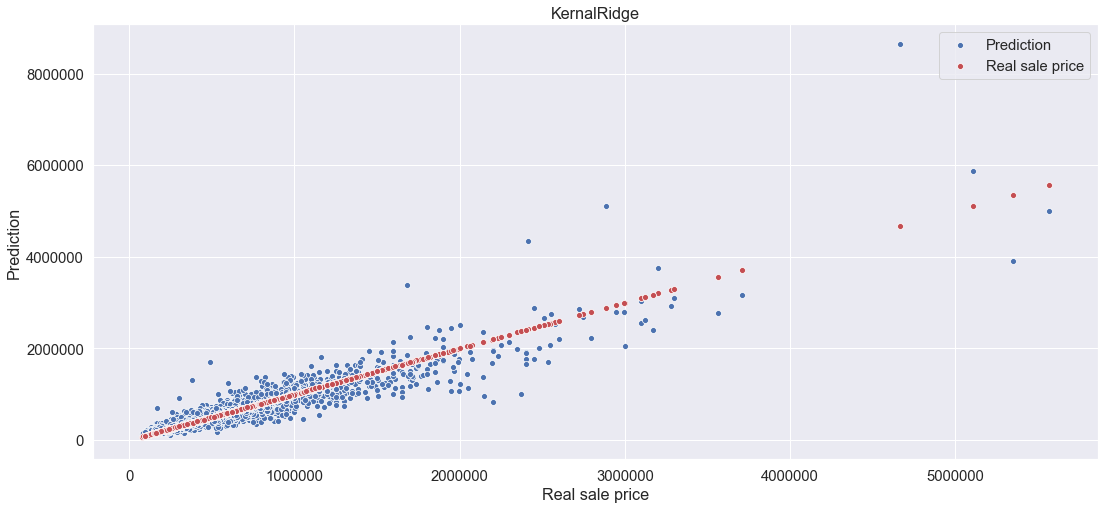

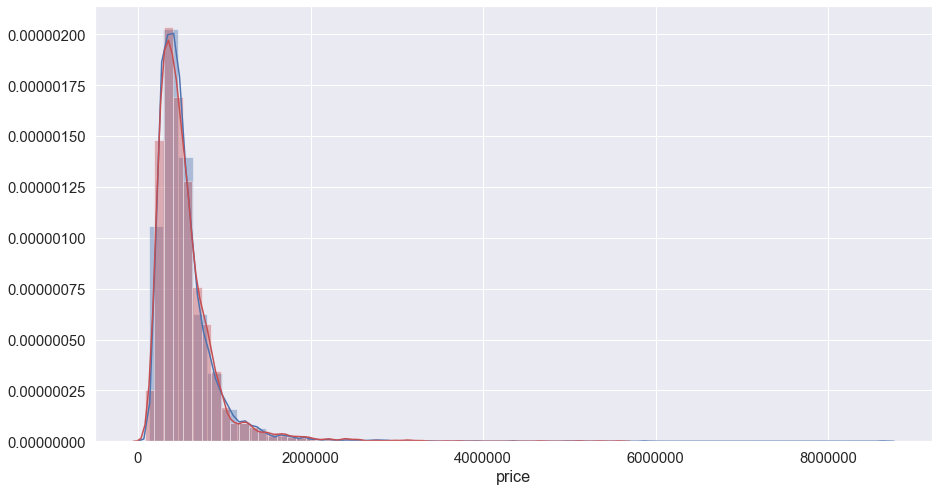

In [56]:
KRR_model.plot()

### XGBoost

In [57]:
XGB = xgb.XGBRegressor(
    colsample_bytree = 0.87, 
    gamma = 0.04, 
    learning_rate = 0.0525, 
    max_depth = 5,
    min_child_weight = 7.78, 
    n_estimators = 1263,
    reg_alpha = 0.95, 
    reg_lambda = 0.1,
    subsample = 0.73, 
    # silent = 1,
    random_state = 7,
    nthread = -1
)

In [58]:
XGB_model = ModelTraining(XGB, X_train, X_test, y_train, y_test, 'XGBoost')

In [59]:
XGB_model.metrics()

--> XGBoost
--- train: 0.9281
--- test: 0.8822
--- mae: 69448.87918413071
--- mape: 13.200000000000001% 



In [60]:
compare = pd.DataFrame()
compare['real_values'] = XGB_model.real_test_target()
compare['predictions'] = XGB_model.test_predictions()
compare['error'] = compare['real_values'] - compare['predictions']
compare.describe().T

,count,mean,std,min,25%,50%,75%,max
real_values,5398.00,540066.53,366987.04,78000.00,325000.00,453750.00,640000.00,5570000.00
predictions,5398.00,533276.12,346180.72,113090.23,324907.68,455025.31,625934.52,5461208.00
error,5398.00,6790.34,117836.87,-1307721.12,-37966.77,2084.68,42941.47,1380619.25


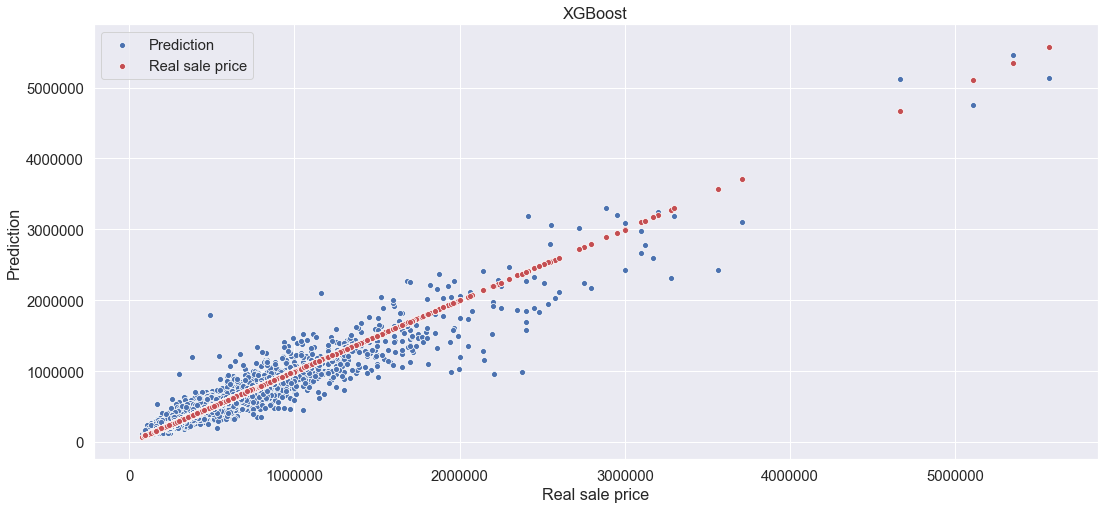

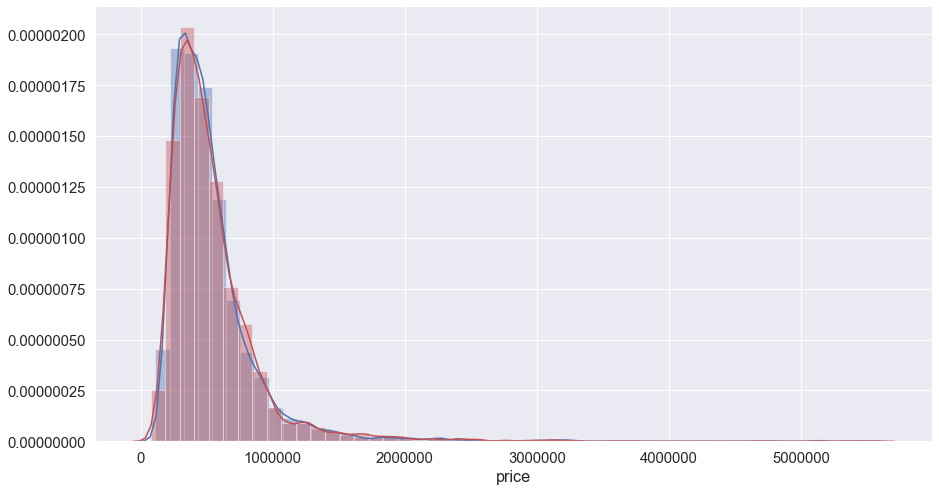

In [61]:
XGB_model.plot()

### LGBM

In [62]:
cat_feat = [
    'bedrooms', 
    'bathrooms', 
    'floors', 
        #'waterfront', 
    'view', 
    'condition', 
    'grade', 
        #'neighborhood',
    'total_rooms', 
        #'basement_living', 
        #'renovated'
]

In [63]:
LGBM = lgb.LGBMRegressor(
    objective='regression',
    max_depth = 6,
    num_leaves = 11,
    learning_rate = 0.0125, 
    n_estimators = 1303,
    max_bin = 95, 
    colsample_bytree = 0.75,
    feature_fraction_seed = 19,
    min_data_in_bin = 100,
    two_round = True,
    #min_data_in_leaf = 10, 
    #min_child_samples = 10,
    #min_sum_hessian_in_leaf = 10
)

In [64]:
LGBM_model = ModelTraining(LGBM, X_train, X_test, y_train, y_test, 'LGBM')

In [65]:
LGBM_model.metrics()

--> LGBM
--- train: 0.8943
--- test: 0.8798
--- mae: 71139.72101746284
--- mape: 13.5% 



In [66]:
compare = pd.DataFrame()
compare['real_values'] = LGBM_model.real_test_target()
compare['predictions'] = LGBM_model.test_predictions()
compare['error'] = compare['real_values'] - compare['predictions']
compare.describe().T

,count,mean,std,min,25%,50%,75%,max
real_values,5398.00,540066.53,366987.04,78000.00,325000.00,453750.00,640000.00,5570000.00
predictions,5398.00,532128.71,336003.70,127474.04,328246.82,454536.10,621243.10,4962343.71
error,5398.00,7937.82,120924.44,-1453892.75,-39715.87,1869.12,44571.54,1611361.28


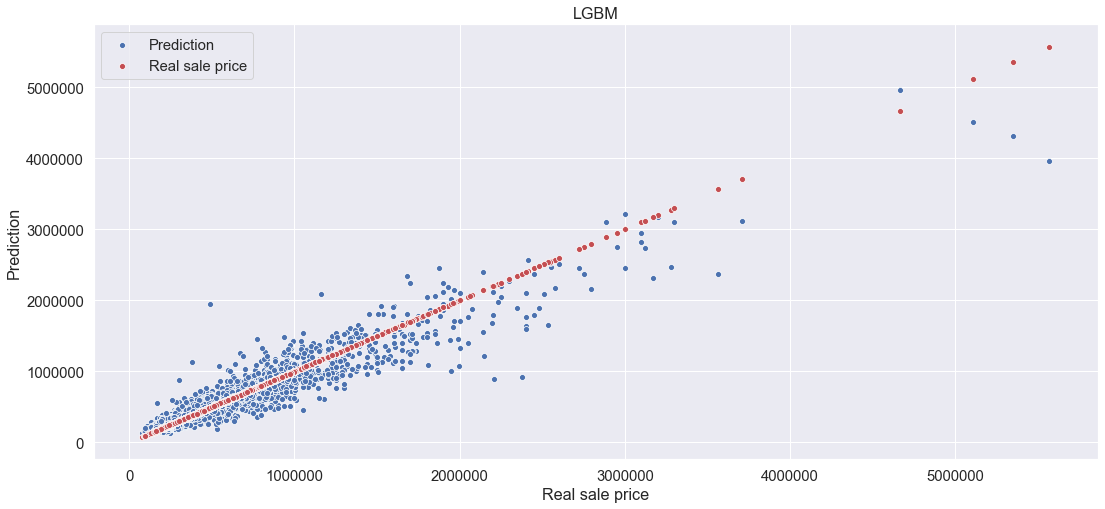

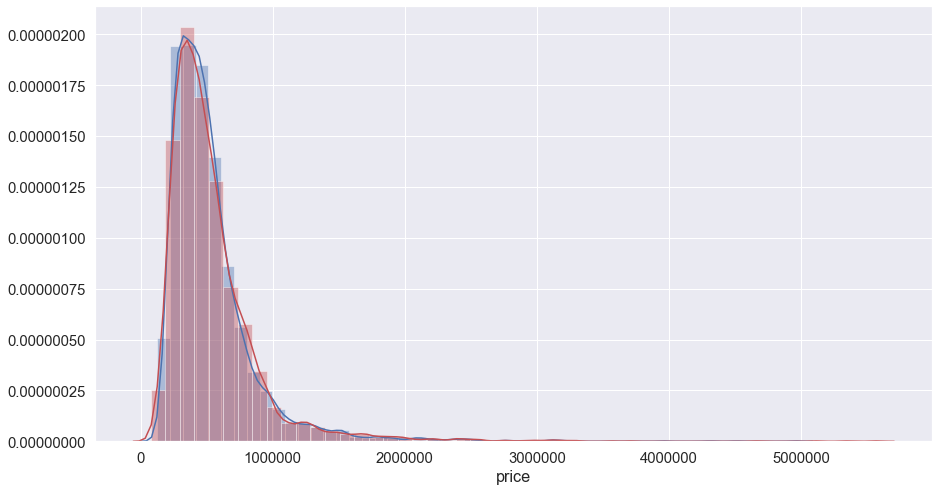

In [67]:
LGBM_model.plot()

### Mixing

In [68]:
Mixed = MixerModels(models = (XGB, LGBM, KRR))
#score = mae_cv(mixed_model)

In [69]:
Mixed_model = ModelTraining(Mixed, X_train, X_test, y_train, y_test, 'Mixed')

In [70]:
Mixed_model.metrics()

--> Mixed
--- train: 0.9061
--- test: 0.8819
--- mae: 70367.47118096436
--- mape: 13.3% 



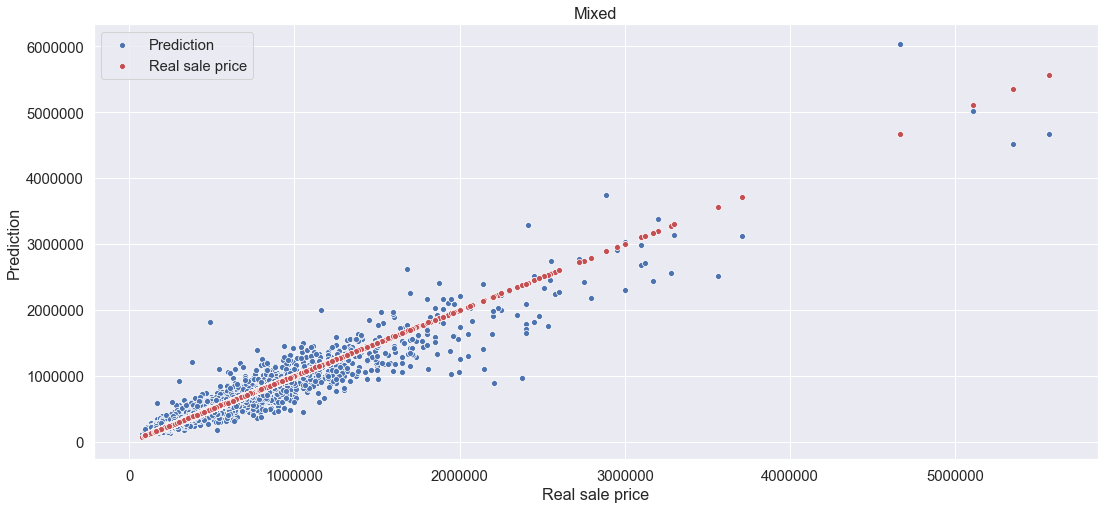

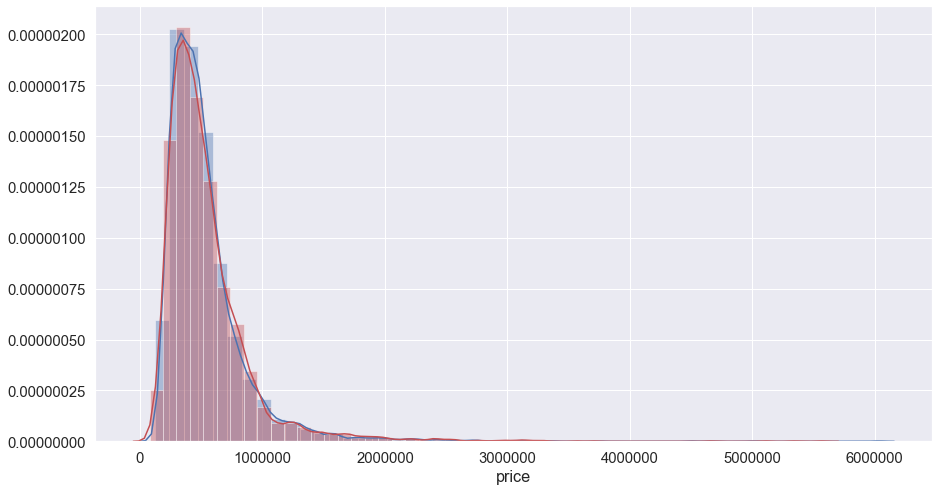

In [71]:
Mixed_model.plot()

In [72]:
compare = pd.DataFrame()
compare['real_values'] = Mixed_model.real_test_target()
compare['predictions'] = Mixed_model.test_predictions()
compare['error'] = compare['real_values'] - compare['predictions']
compare.head()

,real_values,predictions,error
11894,672500.00,715689.53,-43189.53
9086,415000.00,325259.28,89740.72
5917,750000.00,716569.40,33430.60
5403,497000.00,476877.35,20122.65
18771,315000.00,305010.66,9989.34


In [73]:
compare.describe().T

,count,mean,std,min,25%,50%,75%,max
real_values,5398.00,540066.53,366987.04,78000.00,325000.00,453750.00,640000.00,5570000.00
predictions,5398.00,533060.23,344750.83,121143.07,328439.41,455246.18,623655.77,6033667.54
error,5398.00,7006.30,119943.53,-1365667.54,-39267.43,1575.29,43869.69,1401851.28


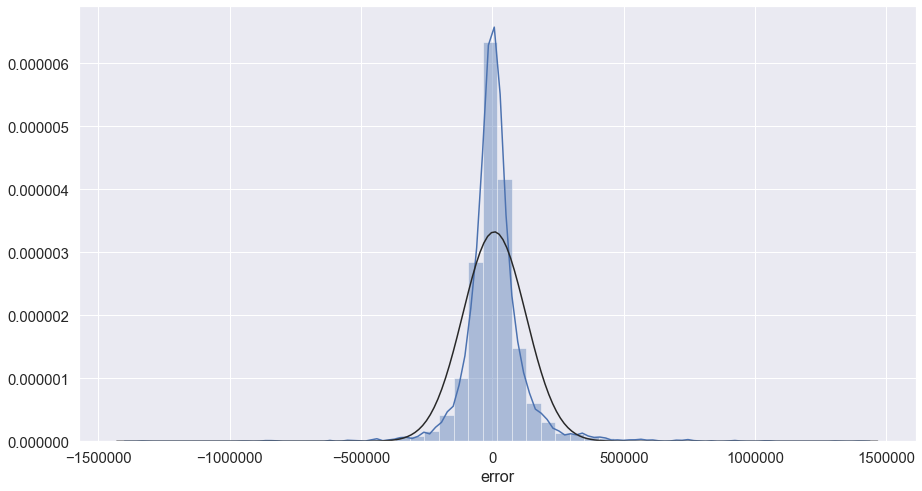

In [74]:
sns.distplot(compare['error'], fit=norm);

In [75]:
compare.query('error > 100000')

,real_values,predictions,error
5066,670000.00,562315.50,107684.50
14975,972000.00,845046.69,126953.31
20197,1104500.00,887128.39,217371.61
2264,618000.00,503893.05,114106.95
8191,2450000.00,1818129.29,631870.71
...,...,...,...
8179,475000.00,268704.94,206295.06
21437,530000.00,421943.83,108056.17
18477,3300000.00,3130146.18,169853.82
12824,291970.00,189989.88,101980.12


In [76]:
compare.query('error < -100000')

,real_values,predictions,error
15690,407000.00,512182.07,-105182.07
3851,210000.00,330094.43,-120094.43
394,1118000.00,1357679.21,-239679.21
7512,470000.00,607943.83,-137943.83
19668,340000.00,478701.96,-138701.96
...,...,...,...
14659,525000.00,638147.92,-113147.92
6133,699000.00,935622.30,-236622.30
1569,797000.00,901313.88,-104313.88
16708,423500.00,614316.90,-190816.90


In [77]:
compare.shape

(5398, 3)

### Model exportation

In [78]:
import pickle

model_to_export = Mixed_model.export()

with open('ml_model_mixer.pkl', 'wb') as file:
    pickle.dump(model_to_export, file)